In [1]:
# Importing needed libraries

import torch, os
import numpy as np
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F



from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torch.autograd import grad
from helpers import *
from torchmetrics.image.inception import InceptionScore
from torchmetrics.image.fid import FrechetInceptionDistance
from CGDs import ACGD

c:\Users\dange\anaconda3\lib\site-packages\torchvision\io\image.py:13: UserWarning: Failed to load image Python extension: [WinError 127] Impossibile trovare la procedura specificata
  warn(f"Failed to load image Python extension: {e}")


In [2]:
class Generator(nn.Module):
    
    def __init__(self, input_dim=100, output_dim=1, input_size=32):
        super(Generator, self).__init__()
        self.input_dim = input_dim 
        self.output_dim = output_dim 
        self.input_size = input_size

        self.fc = nn.Sequential(
            nn.Linear(self.input_dim, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(),
            nn.Linear(1024, 128 * (self.input_size // 4) * (self.input_size // 4)),
            nn.BatchNorm1d(128 * (self.input_size // 4) * (self.input_size // 4)),
            nn.ReLU(),
        )

        # The following layers are used to upsample the input
        # noise and generate an output image.
        self.deconv = nn.Sequential(
            nn.ConvTranspose2d(128, 64, 4, 2, 1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.ConvTranspose2d(64, self.output_dim, 4, 2, 1),
            nn.Tanh(),
        )

        # This function initializes the weights and biases of the 
        # generator's layers:
        initialize_weights(self) 

    def forward(self, input):
        '''
        The input to the forward method represents the input noise 
        to the generator model. It returns the generated output image.
        '''
        
        x = self.fc(input)
        x = x.view(-1, 128, (self.input_size // 4), (self.input_size // 4)) # Reshapes x to match the expected size for the subsequent transposed convolutional layers. 
        x = self.deconv(x)
        return x

In [3]:
class Discriminator(nn.Module):
    def __init__(self, input_dim=1, output_dim=1, input_size=32):
        super(Discriminator, self).__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.input_size = input_size

        self.conv = nn.Sequential(
            nn.Conv2d(self.input_dim, 64, 4, 2, 1),
            nn.LeakyReLU(0.2),
            nn.Conv2d(64, 128, 4, 2, 1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),
        )
        self.fc = nn.Sequential(
            nn.Linear(128 * (self.input_size // 4) * (self.input_size // 4), 1024),
            nn.BatchNorm1d(1024),
            nn.LeakyReLU(0.2),
            nn.Linear(1024, self.output_dim),
            # nn.Sigmoid(),
        )
        
        # This function initializes the weights and biases of the 
        # discriminator's layers:
        initialize_weights(self)

    def forward(self, input):
        '''
        The input to the forward method represents the input image
        It returns the output prediction, which represents the discriminator's assessment of the input image.
        '''
        x = self.conv(input)
        x = x.view(-1, 128 * (self.input_size // 4) * (self.input_size // 4))
        x = self.fc(x)
        return x

In [4]:
class WGAN(object):
    def __init__(self, epoch, batch_size, save_dir, result_dir, dataset, device, input_size, lrG, lrD, beta1, beta2):
        self.epoch = epoch
        self.batch_size = batch_size

        self.save_dir = save_dir
        self.result_dir = result_dir

        self.device = device
        self.dataset = dataset

        self.input_size = input_size    # Default: 32

        self.D_losses = []
        self.G_losses = []
        self.inception_scores = []
        self.frechet_inception_distances = []

        self.model_name = 'WGAN'        
        self.z_dim = 62                 # Represents the dimensionality of the (Gaussian) random input vector used by the generator.
        self.d_param_max = 0.01         # Clipping value
        self.iteration_g_per_d = 5      # Specifies the number of iterations of the generator per discriminator iteration. 
                                        # This controls the relative training frequency of the generator and discriminator.

        self.inception=InceptionScore(normalize=True)
        self.f=FrechetInceptionDistance(feature=64,normalize=True)

        # Transformation to be applied on data in the DataLoader function
        transform = transforms.Compose([
                                        transforms.Resize((input_size, input_size)), 
                                        transforms.ToTensor(), 
                                        transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
                                        ])
        
        if self.dataset == 'cifar10':
                self.data_loader = DataLoader(
                    datasets.CIFAR10('data/cifar10', train=True, download=False, transform=transform),
                    batch_size=batch_size, shuffle=True)
        elif self.dataset == 'mnist':
                self.data_loader = DataLoader(
                    datasets.MNIST('data/mnist', train=True, download=False, transform=transform),
                    batch_size=batch_size, shuffle=True)

        data = self.data_loader.__iter__().__next__()[0]

        # Initialize generator, discriminator and optimizers
        self.G = Generator(input_dim=self.z_dim, output_dim=data.shape[1], input_size=self.input_size)
        self.D = Discriminator(input_dim=data.shape[1], output_dim=1, input_size=self.input_size)
        self.G_optimizer = optim.Adam(self.G.parameters(), lr=lrG, betas=(beta1, beta2))
        self.D_optimizer = optim.Adam(self.D.parameters(), lr=lrD, betas=(beta1, beta2))

        if self.device == 'cuda:0':
            self.G.cuda()
            self.D.cuda()

        # Fixed noise: By setting up a fixed noise vector, the WGAN can generate consistent
        # samples from the generator over the course of training. This allows for visualizing
        # the progression of generated images or comparing them across different training iterations.
        self.sample_z = torch.rand((self.batch_size, self.z_dim))
        if self.device == 'cuda:0':
            self.sample_z = self.sample_z.cuda()

        print('---------------INITIALIZATION-----------------')
        print('|           Model: WGAN with Adam            |')
        print('----------------------------------------------')


    def train(self):
        self.y_real = torch.ones(self.batch_size, 1) # Initialize labels for real samples (i.e. 1)
        self.y_fake = torch.zeros(self.batch_size, 1) # Initialize labels for fake samples (i.e. 0)

        if self.device == 'cuda:0':
            self.y_real = self.y_real.cuda()
            self.y_fake = self.y_fake.cuda()

        self.D.train() #D network in train mode

        print('Start training!')
        tot_iter = 0
        for epoch in range(self.epoch):
            iteration_losses_G = []     # Auxiliary arrays to compute the mean loss for each epoch
            iteration_losses_D = []

            self.G.train() #G network in train mode

            for iter, (x_train, _) in enumerate(self.data_loader):
                if iter == (self.data_loader.dataset.__len__() // self.batch_size): # Exit the loop when it has been used the whole dataset
                    break

                z_noise = torch.rand((self.batch_size, self.z_dim))

                if self.device == 'cuda:0':
                    x_train = x_train.cuda()
                    z_noise = z_noise.cuda()

                # PART 1: UPDATE THE DISCRIMINATOR
                self.D_optimizer.zero_grad()

                D_real = self.D(x_train) # Computes the discriminator output for real data
                D_real_loss = -torch.mean(D_real) # Calculates the loss for the discriminator on real data. 
                                                  # The objective is to maximize the average output of the discriminator for real data.

                G_ = self.G(z_noise) # Generates fake data using the generator
                D_fake = self.D(G_) # Computes the discriminator output for fake data.
                D_fake_loss = torch.mean(D_fake) # Calculates the loss for the discriminator on fake data. 
                                                 # The objective is to minimize the average output of the discriminator for fake data.

                D_loss = D_real_loss + D_fake_loss # Calculates the total discriminator loss as the sum of the losses on real and fake data.

                D_loss.backward()
                self.D_optimizer.step()

                # Clipping D parameters to a specified range to enforce Lipschitz continuity.
                for p in self.D.parameters():
                    p.data.clamp_(-self.d_param_max, self.d_param_max)

                if ((iter+1) % self.iteration_g_per_d) == 0:
                    # PART 2: UPDATE THE GENERATOR
                    self.G_optimizer.zero_grad()

                    G_ = self.G(z_noise)
                    D_fake = self.D(G_)
                    G_loss = -torch.mean(D_fake) # Calculates the generator loss as the negative average output of the discriminator for fake data. 
                                                 # The objective is to maximize the average output of the discriminator for the generated fake data.

                    iteration_losses_G.append(G_loss.item())

                    G_loss.backward()

                    self.G_optimizer.step()

                    iteration_losses_D.append(D_loss.item())
                
                if tot_iter % 1000 == 0:        # Compute the Inception scores and the FID scores every 1000 iterations
                     with torch.no_grad():
                        score=self.IS()
                        self.inception_scores.append(score[0].item())
                        distance=self.FID()
                        self.frechet_inception_distances.append(distance.item())
                tot_iter += 1
            
            self.G_losses.append(np.mean(iteration_losses_G))
            self.D_losses.append(np.mean(iteration_losses_D))

            print(f'Epoch: {epoch+1}/{self.epoch}')
            print(f'Discriminator loss: {self.D_losses[-1]}')
            print(f'Generator loss: {self.G_losses[-1]}')

            with torch.no_grad():
                self.visualize_results((epoch+1))

        print("Training finished.")
        #self.save()
        generate_animation(self.result_dir + '/' + self.dataset + '/' + self.model_name + '/' + self.model_name,
                                 self.epoch)
        loss_plot(self.G_losses, self.D_losses, os.path.join(self.save_dir, self.dataset, self.model_name), self.model_name)
        save_scores(self.inception_scores, self.save_dir, self.dataset, self.model_name, IS=True)
        save_scores(self.frechet_inception_distances, self.save_dir, self.dataset, self.model_name, FID=True)
        save_loss(self.G_losses, self.save_dir, self.dataset, self.model_name, Generator=True)
        save_loss(self.D_losses, self.save_dir, self.dataset, self.model_name, Discriminator=True)
    


    def IS(self):
        self.G.eval()
        images = self.G(self.sample_z)
        self.inception.update(images.cpu())
        IS=self.inception.compute()   
        return IS
        


    def FID(self):
        self.G.eval()
        imagesG = self.G(self.sample_z)
        imagesR=self.data_loader.__iter__().__next__()[0]
        self.f.update(imagesR.cpu(), real=True)
        self.f.update(imagesG.cpu(), real=False)
        FID=self.f.compute()
        return FID



    def visualize_results(self, epoch):
        self.G.eval()

        if not os.path.exists(self.result_dir + '/' + self.dataset + '/' + self.model_name):
            os.makedirs(self.result_dir + '/' + self.dataset + '/' + self.model_name)

        samples = self.G(self.sample_z)
        
        if self.device == 'cuda:0':
            samples = samples.cpu().data.numpy().transpose(0, 2, 3, 1)
        else:
            samples = samples.data.numpy().transpose(0, 2, 3, 1)

        samples = (samples + 1) / 2
        save_images(samples, [8, 8],
                          self.result_dir + '/' + self.dataset + '/' + self.model_name + '/' + self.model_name + '_epoch%03d' % epoch + '.png')
    


    def print_networks(self):
        print('---------- Networks architecture -------------')
        print(self.G)
        print(self.D)
        print('-----------------------------------------------')
        


In [5]:
class WGAN_GP(object):
    def __init__(self, epoch, batch_size, save_dir, result_dir, dataset, device, input_size, lrG, lrD, beta1, beta2):
        self.epoch = epoch
        self.batch_size = batch_size
        self.input_size = input_size

        self.dataset = dataset

        self.save_dir = save_dir
        self.result_dir = result_dir

        self.device = device

        self.model_name = 'WGAN_GP'
        self.z_dim = 62
        self.lambda_ = 10
        self.iteration_g_per_d = 5

        
        self.G_losses = []
        self.D_losses = []
        self.inception_scores = []
        self.frechet_inception_distances = []

        self.inception=InceptionScore(normalize=True)
        self.f=FrechetInceptionDistance(feature=64,normalize=True)
        
        # Transformation to be applied on data in the DataLoader function
        transform = transforms.Compose([
                                transforms.Resize((self.input_size, self.input_size)), 
                                transforms.ToTensor(), 
                                transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
                                ])

        if self.dataset == 'cifar10':
                self.data_loader = DataLoader(
                    datasets.CIFAR10('data/cifar10', train=True, download=False, transform=transform),
                    batch_size=batch_size, shuffle=True)
        elif self.dataset == 'mnist':
                self.data_loader = DataLoader(
                    datasets.MNIST('data/mnist', train=True, download=False, transform=transform),
                    batch_size=batch_size, shuffle=True)
        
        data = self.data_loader.__iter__().__next__()[0]

        # Initialization of optimizers and of generator and discriminator
        self.G = Generator(input_dim=self.z_dim, output_dim=data.shape[1], input_size=self.input_size)
        self.D = Discriminator(input_dim=data.shape[1], output_dim=1, input_size=self.input_size)
        self.G_optimizer = optim.Adam(self.G.parameters(), lr=lrG, betas=(beta1, beta2))
        self.D_optimizer = optim.Adam(self.D.parameters(), lr=lrD, betas=(beta1, beta2))

        if self.device == 'cuda:0':
            self.G.cuda()
            self.D.cuda()

        # Fixed noise: By setting up a fixed noise vector, the WGAN can generate consistent
        # samples from the generator over the course of training. This allows for visualizing
        # the progression of generated images or comparing them across different training iterations.
        self.sample_z = torch.rand((self.batch_size, self.z_dim))
        if self.device == 'cuda:0':
            self.sample_z = self.sample_z.cuda()
        
        print('---------------INITIALIZATION-----------------')
        print('| Model: WGAN with Adam and Gradient Penalty |')
        print('----------------------------------------------')


    def train(self):    
        self.y_real = torch.ones(self.batch_size, 1)
        self.y_fake = torch.zeros(self.batch_size, 1)

        if self.device == 'cuda:0':
            self.y_real = self.y_real.cuda()
            self.y_fake =  self.y_fake.cuda()

        self.D.train() #Discriminator in train mode

        print('Start training!')
        tot_iter = 0
        for epoch in range(self.epoch):
            iteration_losses_G = []                                                  # Auxiliary arrays to compute the mean loss for each epoch
            iteration_losses_D = []
            
            self.G.train()                                                           # Generator in train mode

            for iter, (x_train, _) in enumerate(self.data_loader):
                if iter == self.data_loader.dataset.__len__() // self.batch_size:    # Exit the loop when it has been used the whole dataset
                    break

                z_noise = torch.rand((self.batch_size, self.z_dim))
                if self.device == 'cuda:0':
                    x_train = x_train.cuda()
                    z_noise = z_noise.cuda()

                # PART 1: UPDATE THE DISCRIMINATOR
                self.D_optimizer.zero_grad()

                D_real = self.D(x_train)
                D_real_loss = -torch.mean(D_real)

                G_ = self.G(z_noise)
                D_fake = self.D(G_)
                D_fake_loss = torch.mean(D_fake)

                # Gradient penalty
                alpha = torch.rand((self.batch_size, 1, 1, 1))
                if self.device == 'cuda:0':
                    alpha = alpha.cuda()

                x_hat = alpha * x_train.data + (1 - alpha) * G_.data
                x_hat.requires_grad = True

                pred_hat = self.D(x_hat)
                if self.device == 'cuda:0':
                    gradients = grad(outputs=pred_hat, inputs=x_hat, grad_outputs=torch.ones(pred_hat.size()).cuda(),
                                 create_graph=True, retain_graph=True, only_inputs=True)[0]
                else:
                    gradients = grad(outputs=pred_hat, inputs=x_hat, grad_outputs=torch.ones(pred_hat.size()),
                                     create_graph=True, retain_graph=True, only_inputs=True)[0]

                gradient_penalty = self.lambda_ * ((gradients.view(gradients.size()[0], -1).norm(2, 1) - 1) ** 2).mean()

                D_loss = D_real_loss + D_fake_loss + gradient_penalty # Loss with gradient penalty

                D_loss.backward()
                self.D_optimizer.step()

                if ((iter+1) % self.iteration_g_per_d) == 0:
                    # PART 2: UPDATE THE GENERATOR
                    self.G_optimizer.zero_grad()

                    G_ = self.G(z_noise)
                    D_fake = self.D(G_)
                    G_loss = -torch.mean(D_fake)

                    iteration_losses_G.append(G_loss.item())

                    G_loss.backward()
                    self.G_optimizer.step()

                    iteration_losses_D.append(D_loss.item())
                
                if tot_iter%1000 == 0:
                    with torch.no_grad():
                        score=self.IS()
                        self.inception_scores.append(score[0].item())
                        distance=self.FID()
                        self.frechet_inception_distances.append(distance.item())
                tot_iter += 1

            self.G_losses.append(np.mean(iteration_losses_G))
            self.D_losses.append(np.mean(iteration_losses_D))

            print(f'Epoch: {epoch+1}/{self.epoch}')
            print(f'Average Discriminator loss: {self.D_losses[-1]}')
            print(f'Average Generator loss: {self.G_losses[-1]}\n')
            
            with torch.no_grad():
                self.visualize_results((epoch+1))

        print("Training finished!")

        #self.save()
        generate_animation(self.result_dir + '/' + self.dataset + '/' + self.model_name + '/' + self.model_name,
                                 self.epoch)
        loss_plot(self.G_losses, self.D_losses, os.path.join(self.save_dir, self.dataset, self.model_name), self.model_name)
        save_scores(self.inception_scores, self.save_dir, self.dataset, self.model_name, IS=True)
        save_scores(self.frechet_inception_distances, self.save_dir, self.dataset, self.model_name, FID=True)
        save_loss(self.G_losses, self.save_dir, self.dataset, self.model_name, Generator=True)
        save_loss(self.D_losses, self.save_dir, self.dataset, self.model_name, Discriminator=True)
    


    def IS(self):
        self.G.eval()
        images = self.G(self.sample_z)
        self.inception.update(images.cpu())
        IS=self.inception.compute()   
        return IS
    


    def FID(self):
        self.G.eval()
        imagesG = self.G(self.sample_z)
        imagesR=self.data_loader.__iter__().__next__()[0]
        self.f.update(imagesR.cpu(), real=True)
        self.f.update(imagesG.cpu(), real=False)
        FID=self.f.compute()
        return FID



    def visualize_results(self, epoch, fix=True):
        '''
        By calling this method during the training loop, you can visualize and save the 
        generated samples at regular intervals to monitor the progress 
        of the generator's output over the course of training.
        '''
        self.G.eval()                           # Set the generator in evaluation mode.

        if not os.path.exists(self.result_dir + '/' + self.dataset + '/' + self.model_name):
            os.makedirs(self.result_dir + '/' + self.dataset + '/' + self.model_name)

        samples = self.G(self.sample_z)         # These samples represent the generator's output at the given epoch        
        
        # The dimensions are transposed to match the image format
        if self.device == 'cuda:0':
            samples = samples.cpu().data.numpy().transpose(0, 2, 3, 1)
        else:
            samples = samples.data.numpy().transpose(0, 2, 3, 1)
        samples = (samples + 1) / 2             # Normalizes the samples by scaling their pixel 
                                                # values from the range [-1, 1] to the range [0, 1]
        save_images(samples, [8, 8],
                          self.result_dir + '/' + self.dataset + '/' + self.model_name + '/' + self.model_name + '_epoch%03d' % epoch + '.png')



    def print_networks(self):
        print('---------- Networks architecture -------------')
        print(self.G)
        print(self.D)
        print('-----------------------------------------------')


In [6]:
class WGAN_ACGD(object):
    def __init__(self, epoch, batch_size, save_dir, result_dir, dataset, device, input_size, lrG, lrD):
        self.epoch = epoch
        self.batch_size = batch_size
        self.input_size = input_size

        self.dataset = dataset

        self.save_dir = save_dir
        self.result_dir = result_dir
        
        self.device = device

        self.model_name = 'WGAN_ACGD'
        self.z_dim = 62
        self.lambda_ = 10
        self.d_param_max = 0.01

        
        self.losses = []
        self.inception_scores = []
        self.frechet_inception_distances = []
        
        self.inception=InceptionScore(normalize=True)
        self.f=FrechetInceptionDistance(feature=64,normalize=True)               
        
        # Transformation to be applied on data in the DataLoader function
        transform = transforms.Compose([
                                transforms.Resize((self.input_size, self.input_size)), 
                                transforms.ToTensor(), 
                                transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
                                ])

        if self.dataset == 'cifar10':
                self.data_loader = DataLoader(
                    datasets.CIFAR10('data/cifar10', train=True, download=False, transform=transform),
                    batch_size=batch_size, shuffle=True)
        elif self.dataset == 'mnist':
                self.data_loader = DataLoader(
                    datasets.MNIST('data/mnist', train=True, download=False, transform=transform),
                    batch_size=batch_size, shuffle=True)
        
        data = self.data_loader.__iter__().__next__()[0]

        # Initialization of optimizers and of generator and discriminator
        self.G = Generator(input_dim=self.z_dim, output_dim=data.shape[1], input_size=self.input_size)
        self.D = Discriminator(input_dim=data.shape[1], output_dim=1, input_size=self.input_size)
        self.optimizer = ACGD(max_params=self.G.parameters(), min_params=self.D.parameters(), lr_max=lrG, lr_min=lrD)
        

        if self.device == 'cuda:0':
            self.G.cuda()
            self.D.cuda()

        # Fixed noise: By setting up a fixed noise vector, the WGAN can generate consistent
        # samples from the generator over the course of training. This allows for visualizing
        # the progression of generated images or comparing them across different training iterations.
        self.sample_z = torch.rand((self.batch_size, self.z_dim))
        if self.device == 'cuda:0':
            self.sample_z = self.sample_z.cuda()

        print('----------------------INITIALIZATION------------------------')
        print('| Model: WGAN using Competitive Gradient Descent optimizer |')
        print('------------------------------------------------------------')
        

    def train(self):
        self.y_real = torch.ones(self.batch_size, 1)    # Initialize labels for real samples (i.e. 1)
        self.y_fake = torch.zeros(self.batch_size, 1)   # Initialize labels for fake samples (i.e. 0)

        if self.device == 'cuda:0':
            self.y_real = self.y_real.cuda()
            self.y_fake = self.y_fake.cuda()

        self.D.train()                                  #D network in train mode

        print('Start training!')
        tot_iter = 0
        for epoch in range(self.epoch):
            self.G.train()                              # G network in train mode
            iteration_losses = []                       # Auxilary array to compute the mean loss for each epoch
            for iter, (x_train, _) in enumerate(self.data_loader):
                if iter == self.data_loader.dataset.__len__() // self.batch_size:
                    break

                z_noise = torch.rand((self.batch_size, self.z_dim))

                if self.device == 'cuda:0':
                    x_train = x_train.cuda()
                    z_noise = z_noise.cuda()

                # UPDATE NETWORKS
                self.optimizer.zero_grad()

                D_real = self.D(x_train)                # Computes the discriminator output for real data
                D_real_loss = -torch.mean(D_real)       # Calculates the loss for the discriminator on real data. 
                                                        # The objective is to maximize the average output of the discriminator for real data.

                G_ = self.G(z_noise)                    # Generates fake data using the generator
                D_fake = self.D(G_)                     # Computes the discriminator output for fake data.
                D_fake_loss = torch.mean(D_fake)        # Calculates the loss for the discriminator on fake data. 
                                                        # The objective is to minimize the average output of the discriminator for fake data.

                loss = D_real_loss + D_fake_loss        # Calculates the total discriminator loss as the sum of the losses on real and fake data.
                
                iteration_losses.append(loss.detach().cpu())
                self.optimizer.step(loss=loss)

                # Clipping D parameters to a specified range to enforce Lipschitz continuity.
                for p in self.D.parameters():
                    p.data.clamp_(-self.d_param_max, self.d_param_max)
                
                if tot_iter%1000 == 0:
                    with torch.no_grad():
                        score=self.IS()
                        self.inception_scores.append(score[0].item())
                        distance=self.FID()
                        self.frechet_inception_distances.append(distance.item())
                tot_iter += 1

            self.losses.append(np.mean(iteration_losses))

            print(f'Epoch: {epoch+1}/{self.epoch}')
            print(f'Average loss: {self.losses[-1]}')

            with torch.no_grad():
                self.visualize_results((epoch+1))

        print("Training finished.")

        generate_animation(self.result_dir + '/' + self.dataset + '/' + self.model_name + '/' + self.model_name,
                                 self.epoch)
        loss_plot_ACGD(self.losses, os.path.join(self.save_dir, self.dataset, self.model_name), self.model_name)
        save_scores(self.inception_scores, self.save_dir, self.dataset, self.model_name, IS=True)
        save_scores(self.frechet_inception_distances, self.save_dir, self.dataset, self.model_name, FID=True)
        save_loss(self.losses, self.save_dir, self.dataset, self.model_name)


    def visualize_results(self, epoch):
        self.G.eval()

        if not os.path.exists(self.result_dir + '/' + self.dataset + '/' + self.model_name):
            os.makedirs(self.result_dir + '/' + self.dataset + '/' + self.model_name)

        samples = self.G(self.sample_z)
        if self.device == 'cuda:0':
            samples = samples.cpu().data.numpy().transpose(0, 2, 3, 1)
        else:
            samples = samples.data.numpy().transpose(0, 2, 3, 1)

        samples = (samples + 1) / 2
        save_images(samples, [8, 8],
                          self.result_dir + '/' + self.dataset + '/' + self.model_name + '/' + self.model_name + '_epoch%03d' % epoch + '.png')
    


    def IS(self):
        self.G.eval()
        images = self.G(self.sample_z)
        self.inception.update(images.cpu())
        IS=self.inception.compute()   
        return IS



    def FID(self):
        self.G.eval()
        imagesG = self.G(self.sample_z)
        imagesR=self.data_loader.__iter__().__next__()[0]
        self.f.update(imagesR.cpu(), real=True)
        self.f.update(imagesG.cpu(), real=False)
        FID=self.f.compute()
        return FID
    

    def save_scores_loss(self):
        save_scores


    def print_networks(self):
        print('---------- Networks architecture -------------')
        print(self.G)
        print(self.D)
        print('-----------------------------------------------')

In [7]:
# PARAMETERS

# Define dataset ['cifar10', 'mnist']
dataset = 'cifar10'

# Define WGAN type [WGAN, WGAN_GP, WGAN_ACGD]
gan_type = 'WGAN'

# Define number of epoch
epoch = 100

# Define batch_size
batch_size = 64

# Define input_size
input_size = 32

# Define directory for saving results and models
save_dir = 'models'
result_dir = 'results'


# Defining learning rates
lrG = 0.0001        # Generator
lrD = 0.0001        # Discriminator

# Adam beta parameters
beta1 = 0.5
beta2 = 0.9

# 'cuda' if GPU is available, 'cpu' else
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

if gan_type == 'WGAN':
    wgan = WGAN(epoch, batch_size, save_dir, result_dir, dataset, device, input_size, lrG, lrD, beta1, beta2)
elif gan_type == 'WGAN_GP':
    wgan = WGAN_GP(epoch, batch_size, save_dir, result_dir, dataset, device, input_size, lrG, lrD, beta1, beta2)
elif gan_type == 'WGAN_ACGD':
    wgan = WGAN_ACGD(epoch, batch_size, save_dir, result_dir, dataset, device, input_size, lrG, lrD)


c:\Users\dange\anaconda3\lib\site-packages\torchmetrics\utilities\prints.py:36: UserWarning: Metric `InceptionScore` will save all extracted features in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)


----------------------INITIALIZATION------------------------
| Model: WGAN using Competitve Gradient Descent optimizer. |
------------------------------------------------------------


Start training!
Epoch: 1/1
Average loss: -0.018492093309760094


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Training finished.


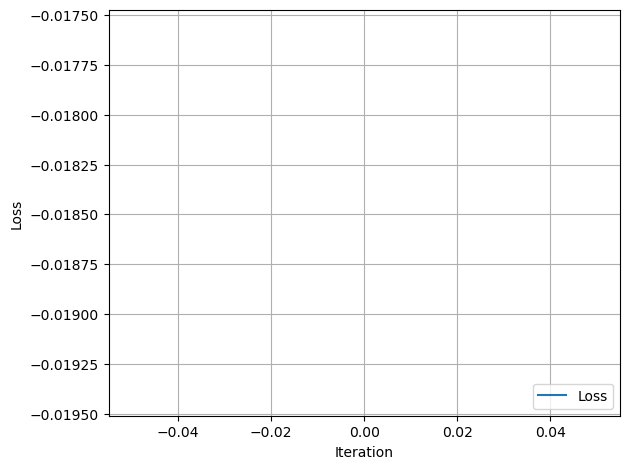

TypeError: save_loss() got an unexpected keyword argument 'ACGD'

In [8]:
wgan.train()
